# Firefox engineering mc-to-nightly time trends

Has the time from when a changeset is commited to the mozilla-central code repository until it is available for download in a nightly build changed significantly over the last three years?

In [1]:
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

We'll use a 3 month block, January to March in 2016, 2017, and 2018.  This should eliminate any large month-to-month effects.  The data should also be consistant because no major team event happens during these months.

In [2]:
files = ['data/nightly-{}{}.parq'.format(y, m)
         for y in (2016, 2017, 2018) 
         for m in ('01', '02', '03')]

In [3]:
df = pd.concat([pd.read_parquet(fn) for fn in files], ignore_index=True)
df.shape

(40092, 8)

In [4]:
df['year'] = df['nightly_publish_time'].dt.year

Localize the push time to UTC so it can be compared with other times.

In [5]:
df['changeset_pushtime'] = df['changeset_pushtime'].dt.tz_localize('UTC')

In [6]:
df.groupby('year').size()

year
2016    11793
2017    16167
2018    12132
dtype: int64

In [7]:
print("Number of unique builds per year")
df.groupby('year')['nightly_build_id'].nunique()

Number of unique builds per year


year
2016     85
2017     88
2018    167
Name: nightly_build_id, dtype: int64

Calculate the number of hours from a changeset being pushed to mozilla-central until the time the changeset was published as a nightly build.

In [8]:
df['push_to_publish'] = df['nightly_publish_time'] - df['changeset_pushtime']
df['hours'] = df['push_to_publish'].dt.total_seconds() / 3600
df['hours'].describe()

count    40092.000000
mean        11.924309
std          9.992328
min          0.910556
25%          2.797222
50%         11.264444
75%         16.618333
max         59.100556
Name: hours, dtype: float64

Pushes are done in batches.  When we calculate the hours from push-to-publish we want to take just the first changeset in the batch of pushes as representative of all changesets in that push batch.

In [9]:
# Builds can have multiple changesets.  Changesets are all members of the same pushid.
# Take only the build time in one record for each push.
pushes = df.groupby(['year', 'changeset_pushid']).first()
groupedhours = pushes.groupby('year')['hours']

In [10]:
groupedhours.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2016,270.0,13.456762,9.734639,2.463333,3.048125,12.654028,21.361042,50.837778
2017,348.0,15.272981,9.664937,0.910556,10.111181,13.267500,21.227222,59.100556
2018,483.0,6.022487,6.067337,1.411389,1.935694,2.598611,8.819861,37.815278


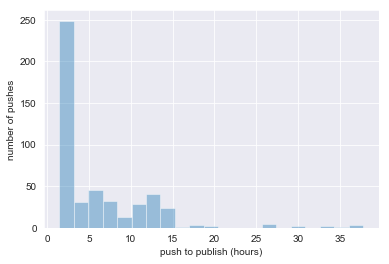

In [11]:
ax = sns.distplot(groupedhours.get_group(2018), kde=False)
ax.set(xlabel="push to publish (hours)", ylabel="number of pushes");

Is there a noticable change across years?

We can compare years using a cumulative distribution function.

We can see that build times were similar, or even slightly worse, from Jan-Mar 2016 and Jan-Mar 2017.  

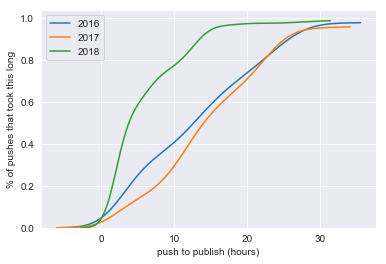

In [12]:
for year, data in groupedhours:
    ax = sns.kdeplot(data, label=year, cumulative=True, clip=(0, 30))
    ax.set(xlabel="push to publish (hours)", ylabel="% of pushes that took this long")

We can see an even clearer difference in the build time trends if we compare the build times from Jan-Mar 2017 to Jan-Mar 2018.

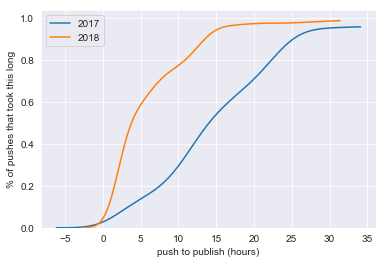

In [13]:
for year in (2017, 2018):
    data = groupedhours.get_group(year)
    ax = sns.kdeplot(data, label=year, cumulative=True, clip=(0, 30))
    ax.set(xlabel="push to publish (hours)", ylabel="% of pushes that took this long")